In [70]:
#Import Libraries
import subprocess
import re
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
import seaborn as sns

from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table
from scipy import interp
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification


from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, LeaveOneOut, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

## Methylation

In [71]:
dset_res=pd.read_csv ("clintab_GMQL/methylation/res/res_meth.csv", delimiter='\t')
dset_sens=pd.read_csv ("clintab_GMQL/methylation/ss_32m/ss_meth.csv", delimiter='\t')
dset_senl=pd.read_csv ("clintab_GMQL/methylation/sl_32m/sl_meth.csv", delimiter='\t')

In [9]:
dset_res.head(1)

,patient,chrom,start,stop,beta_value,gene_symbol,gene_type,ensemble_transcript_id,feature_type
0,R_00000,chr1,924804,924806,0.006785,SAMD11,protein_coding,ENST00000342066.6|ENST00000420190.4|ENST000004...,Island


In [72]:
dset_res["position"] = dset_res["chrom"] + '_' + dset_res["start"].map(str) + '-' + dset_res["stop"].map(str)
dset_sens["position"] = dset_sens["chrom"] + '_' + dset_sens["start"].map(str) + '-' + dset_sens["stop"].map(str)
dset_senl["position"] = dset_senl["chrom"] + '_' + dset_senl["start"].map(str) + '-' + dset_senl["stop"].map(str)

In [73]:
patient = []
genes = []
beta_value_m_r = []

for p in tqdm(dset_res['patient'].unique()):
    x=dset_res[dset_res['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_m=y["beta_value"].agg(np.median)
    
    for index, value in z_m.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_m_r.append(value)

100%|██████████| 60/60 [00:08<00:00,  7.82it/s]


In [74]:
df_res_m = pd.DataFrame(list(zip(patient, genes, beta_value_m_r)), 
               columns =['patient', 'genes', 'beta_value_m'])  
#df_res_m.head()
#df_res_m[df_res_m['patient'] == 'R_00001']

In [75]:
patient = []
genes = []
beta_value_m_ss = []

for p in tqdm(dset_sens['patient'].unique()):
    x=dset_sens[dset_sens['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_m=y["beta_value"].agg(np.median)
    
    for index, value in z_m.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_m_ss.append(value)

100%|██████████| 107/107 [00:21<00:00,  4.95it/s]


In [76]:
df_sens_m = pd.DataFrame(list(zip(patient, genes, beta_value_m_ss)), 
               columns =['patient', 'genes', 'beta_value_m'])  
df_sens_m.head()

,patient,genes,beta_value_m
0,SS_00000,A1BG-AS1,0.960784
1,SS_00000,A1CF,0.532057
2,SS_00000,A2M,0.769686
3,SS_00000,A2ML1-AS1,0.615195
4,SS_00000,A4GALT,0.329131


In [77]:
patient = []
genes = []
beta_value_m_sl = []

for p in tqdm(dset_senl['patient'].unique()):
    x=dset_senl[dset_senl['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_m=y["beta_value"].agg(np.median)
    
    for index, value in z_m.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_m_sl.append(value)

100%|██████████| 34/34 [00:03<00:00, 11.20it/s]


In [78]:
df_senl_m = pd.DataFrame(list(zip(patient, genes, beta_value_m_sl)), 
               columns =['patient', 'genes', 'beta_value_m'])  
#df_senl_m.head()

In [79]:
patient = []
genes = []
beta_value_c = []

for p in tqdm(dset_res['patient'].unique()):
    x=dset_res[dset_res['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_c=y["beta_value"].agg('count')
    
    for index, value in z_c.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_c.append(value)

100%|██████████| 60/60 [00:08<00:00,  7.50it/s]


In [80]:
df_res_c = pd.DataFrame(list(zip(patient, genes, beta_value_c)), 
               columns =['patient', 'genes', 'beta_value_c'])  
#df_res_c.head()

In [81]:
patient = []
genes = []
beta_value_c = []

for p in tqdm(dset_sens['patient'].unique()):
    x=dset_sens[dset_sens['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_c=y["beta_value"].agg('count')
    
    for index, value in z_c.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_c.append(value)

100%|██████████| 107/107 [00:22<00:00,  4.50it/s]


In [82]:
df_sens_c = pd.DataFrame(list(zip(patient, genes, beta_value_c)), 
               columns =['patient', 'genes', 'beta_value_c'])  
#df_sens_c.head()

In [83]:
patient = []
genes = []
beta_value_c = []

for p in tqdm(dset_senl['patient'].unique()):
    x=dset_senl[dset_senl['patient']== p]
    y=x.groupby(x["gene_symbol"])
    z_c=y["beta_value"].agg('count')
    
    for index, value in z_c.iteritems(): 
        #print(index, value)
        patient.append(p)
        genes.append(index)
        beta_value_c.append(value)

100%|██████████| 34/34 [00:02<00:00, 12.63it/s]


In [84]:
df_senl_c = pd.DataFrame(list(zip(patient, genes, beta_value_c)), 
               columns =['patient', 'genes', 'beta_value_c'])  
#df_senl_c.head()

In [124]:
resdf=df_res_m.pivot(index="patient", columns="genes", values="beta_value_m")
genes = resdf.columns.tolist()
#resdf.head()
#resdf.shape

In [125]:
senldf=df_senl_m.pivot(index="patient", columns="genes", values="beta_value_m")
senldf = senldf[genes]
#senldf.head()
#senldf.shape

In [126]:
sensdf=df_sens_m.pivot(index="patient", columns="genes", values="beta_value_m")
sensdf = sensdf[genes]
#sensdf.head()
#sensdf.shape

In [113]:
resdf_median = resdf.median(0)
senldf_median = senldf.median(0)
sensdf_median = sensdf.median(0)

In [127]:
sendf=pd.concat([senldf, sensdf])

In [128]:
resdf_median = resdf.median(0)
sendf_median = sendf.median(0)

In [129]:
pvalues = []
for gene in tqdm(genes):
    try:
        gene_pvalue = scipy.stats.mannwhitneyu(sendf[gene], resdf[gene]).pvalue
    except Exception:
        gene_pvalue = 1
    pvalues.append(gene_pvalue)
       
pvalues = pd.DataFrame({
    "gene": genes,
    "resistant_median": resdf_median.values,
    "sensitive_median": sendf_median.values,
    #"sensitive_long_median": senldf_median.values,
    #"sensitive_short_median": sensdf_median.values,
    "mannwhiteney_pvalue": pvalues
})

pvalues.head()

100%|██████████| 14887/14887 [00:07<00:00, 2102.04it/s]


,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
0,A1BG-AS1,0.974877,0.980623,0.046346
1,A1CF,0.495290,0.539873,0.356805
2,A2M,0.679519,0.653433,0.317159
3,A2ML1-AS1,0.703293,0.626943,0.144280
4,A4GALT,0.258818,0.267151,0.261964


## Selection from p_value

In [130]:
threshold = 0.005

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

65


In [131]:
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()
#significant_genes.to_csv('new_data/miRNA/r_sl_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/miRNA/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/miRNA/sl_ss_pv2.csv', sep=',', header=True, index=False)

,gene,resistant_median,sensitive_median,mannwhiteney_pvalue
11094,RP11-886P16.10,0.032653,0.025334,0.000166
2989,CTB-55O6.10,0.032936,0.047202,0.000530
7571,MLXIP,0.931693,0.943157,0.000651
297,ACKR2,0.132828,0.254940,0.000803
13500,TOP1,0.049645,0.044154,0.000841


In [31]:
lista=list(significant_genes['gene'])
type(lista)

list

In [32]:
dset_sens.head()

,patient,chrom,start,stop,beta_value,gene_symbol,gene_type,ensemble_transcript_id,feature_type,position
0,SS_00000,chr1,924804,924806,0.007873,SAMD11,protein_coding,ENST00000342066.6|ENST00000420190.4|ENST000004...,Island,chr1_924804-924806
1,SS_00000,chr1,925936,925938,0.114492,SAMD11,protein_coding,ENST00000342066.6|ENST00000420190.4|ENST000004...,Island,chr1_925936-925938
2,SS_00000,chr1,959206,959208,0.011180,NOC2L,protein_coding,ENST00000327044.6|ENST00000469563.1|ENST000004...,Island,chr1_959206-959208
3,SS_00000,chr1,959573,959575,0.717861,NOC2L,protein_coding,ENST00000327044.6|ENST00000469563.1|ENST000004...,Island,chr1_959573-959575
4,SS_00000,chr1,966644,966646,0.010098,PLEKHN1,protein_coding,ENST00000379407.6|ENST00000379409.5|ENST000003...,Island,chr1_966644-966646


In [33]:
x = dset_sens[dset_sens.gene_symbol.isin(lista)]
y=pd.DataFrame(x)
y.head()
y.to_csv('new_data/methylation/SL_R_last.csv', sep=',', header=True, index=False)

In [132]:
column=significant_genes['gene']
column.head()

11094    RP11-886P16.10
2989        CTB-55O6.10
7571              MLXIP
297               ACKR2
13500              TOP1
Name: gene, dtype: object

In [ ]:
lista=column.values
np.save("meth_stot_vs_res.npy", lista)

## Bonferroni, len(p_values)

In [ ]:
threshold = 0.5

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])
significant_genes=pd.DataFrame(significant_genes)

In [ ]:
p_value_corr =[]

for index, value in tqdm(significant_genes['gene'].iteritems()): 
        #print(index, value)
        #x=df_res_c[df_res_c['genes']==value]
        #y=df_sens_c[df_sens_c['genes']==value]
        #z=df_senl_c[df_senl_c['genes']==value]
        #x_s=x['beta_value_c'].sum()
        #y_s=y['beta_value_c'].sum()
        #z_s=z['beta_value_c'].sum()
        #somma=y_s+z_s
        somma=len(significant_genes)
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value)

In [ ]:
pvalues['p_value_corr']=p_value_corr
#pvalues.head()

In [ ]:
threshold = 0.05

significant_genes_corr = pvalues[(pvalues.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

In [ ]:
column=significant_genes_corr['gene']
column.head()

## Bonferroni, len(patients)

In [90]:
threshold = 0.005

significant_genes = pvalues[(pvalues.mannwhiteney_pvalue < threshold)].copy()
significant_genes = significant_genes.sort_values("mannwhiteney_pvalue", ascending=True)
print(significant_genes.shape[0])

135


In [91]:
significant_genes=pd.DataFrame(significant_genes)
significant_genes.head()

,gene,sensitive_long_median,sensitive_short_median,mannwhiteney_pvalue
10225,RILP,0.335616,0.289588,0.000006
11856,SKIV2L,0.931839,0.894482,0.000009
9200,PLEKHB1,0.568565,0.274356,0.000033
14170,VPS37B,0.429182,0.219542,0.000062
5787,HSPB2,0.651816,0.577727,0.000070


In [92]:
p_value_corr =[]

for index, value in tqdm(significant_genes['gene'].iteritems()): 
        #print(index, value)
        #x=df_res_c[df_res_c['genes']==value]
        y=df_sens_c[df_sens_c['genes']==value]
        z=df_senl_c[df_senl_c['genes']==value]
        #x_s=x['beta_value_c'].sum()
        y_s=y['beta_value_c'].sum()
        z_s=z['beta_value_c'].sum()
        somma=z_s+y_s
        #somma=len(significant_genes)
        p_value=pvalues[pvalues['gene']==value]['mannwhiteney_pvalue'].iloc[0]
        p_value_corr.append(somma*p_value)
        #print(p_value)

135it [00:29,  4.51it/s]


In [93]:
significant_genes['p_value_corr']=p_value_corr

In [94]:
threshold = 0.05

significant_genes_corr = significant_genes[(significant_genes.p_value_corr < threshold)].copy()
significant_genes_corr = significant_genes_corr.sort_values("mannwhiteney_pvalue", ascending=True)
significant_genes_corr=pd.DataFrame(significant_genes_corr)
print(significant_genes_corr.shape[0])
significant_genes_corr.head()

10


,gene,sensitive_long_median,sensitive_short_median,mannwhiteney_pvalue,p_value_corr
10225,RILP,0.335616,0.289588,0.000006,0.001576
11856,SKIV2L,0.931839,0.894482,0.000009,0.003747
9200,PLEKHB1,0.568565,0.274356,0.000033,0.009131
14170,VPS37B,0.429182,0.219542,0.000062,0.017429
5787,HSPB2,0.651816,0.577727,0.000070,0.018905


In [41]:
lista=list(significant_genes_corr['gene'])
type(lista)

list

In [42]:
x = dset_sens[dset_sens.gene_symbol.isin(lista)]
y=pd.DataFrame(x)
y.head()
y.to_csv('new_data/methylation/SS_SL_last.csv', sep=',', header=True, index=False)

In [ ]:
#significant_genes.to_csv('new_data/gene_exprs/r_sl_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/r_ss_pv2.csv', sep=',', header=True, index=False)
#significant_genes.to_csv('new_data/gene_exprs/sl_ss_pv2.csv', sep=',', header=True, index=False)

In [95]:
column=significant_genes_corr['gene']
column.head()

10225       RILP
11856     SKIV2L
9200     PLEKHB1
14170     VPS37B
5787       HSPB2
Name: gene, dtype: object

In [ ]:
lista=column.values
np.save("meth_ss_vs_sl.npy", lista)

## FDR 

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
a=p_sorted['mannwhiteney_pvalue'].get_values()
enumerate(a)

In [ ]:
num_total_tests=len(a)

In [ ]:
def calc_benjamini_hochberg_corrections(p_values, num_total_tests):
   
    p_value_bh = []
    for i, p_value in enumerate(p_values):
        bh_value = p_value * num_total_tests / (i + 1)
        p_value_bh.append(bh_value)
    return (p_value_bh)

In [ ]:
p_value_corr_bh=calc_benjamini_hochberg_corrections(a, num_total_tests)

In [ ]:
p_sorted['p_value_corr_bh']=p_value_corr_bh

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
print(significant_genes_bh.shape[0])

In [ ]:
column=significant_genes_bh['gene']
column.head()

In [ ]:
significant_genes_bh=pd.read_csv ("new_data/methylation/r_ss_meth_corretta.csv", delimiter=',')
significant_genes_bh

## Benjamini-Hochberg, len(patients)

In [ ]:
n_res=len(dset_res['patient'].unique())
n_sens=len(dset_sens['patient'].unique())
n_senl=len(dset_senl['patient'].unique())
n_sen=n_sens+n_senl

In [ ]:
p_sorted=pvalues.sort_values(by='mannwhiteney_pvalue')

In [ ]:
a=p_sorted['mannwhiteney_pvalue'].get_values()

In [ ]:
enumerate(a)

In [ ]:
num_total_tests=n_res+n_sen #inserisci il num pazienti

In [ ]:
def calc_benjamini_hochberg_corrections(p_values, num_total_tests):
   
    p_value_bh = []
    for i, p_value in enumerate(p_values):
        bh_value = p_value * num_total_tests / (i + 1)
        p_value_bh.append(bh_value)
    return (p_value_bh)

In [ ]:
p_value_corr_bh=calc_benjamini_hochberg_corrections(a, num_total_tests)

In [ ]:
p_sorted['p_value_corr_bh']=p_value_corr_bh

In [ ]:
p_sorted.head()

In [ ]:
threshold = 0.05

significant_genes_bh = p_sorted[(p_sorted.p_value_corr_bh < threshold)].copy()
significant_genes_bh = significant_genes_bh.sort_values("p_value_corr_bh", ascending=True)
print(significant_genes_bh.shape[0])

In [ ]:
significant_genes_bh=pd.DataFrame(significant_genes_bh)
significant_genes_bh.head()

In [ ]:
#significant_genes_bh.to_csv('new_data/gene_exprs/sl_ss_bh_ge.csv', sep=',', header=True, index=False)

In [ ]:
column=significant_genes_bh['gene']
column.head()

## Classification

In [133]:
res_selected=resdf[column]
res_selected["label"]=1
res_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(60, 66)

In [108]:
senl_selected=senldf[column]
senl_selected["label"]=0
senl_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(34, 19)

In [119]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(107, 32)

In [134]:
sen_selected=sendf[column]
sen_selected["label"]=0
sen_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(141, 66)

In [135]:
#concatenated=pd.concat([res_selected, senl_selected])
#concatenated=pd.concat([res_selected, sens_selected])
#concatenated=pd.concat([senl_selected, sens_selected])
concatenated=pd.concat([res_selected, sen_selected])

In [136]:
concatenated=concatenated.dropna(axis=1, how='any', thresh=None, subset=None, inplace=False)

In [137]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [ ]:
precision=[]
recall=[]

#loo = LeaveOneOut()
#loo.get_n_splits(X)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=36851234)
for train_index, test_index in (rskf.split(X, y)) :
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

clf = svm.SVC(kernel='rbf', class_weight='balanced')
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

    clf.fit(X_train, y_train)
    y_predict=clf.predict(X_test)
    
    precision.append(precision_score(y_test, y_predict))
    recall.append(recall_score(y_test, y_predict))

In [ ]:
#kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_res', 'false_senl', 'true_senl', 'false_res', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    print (i)
    i=i+1

In [ ]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Average f1_score: ', np.mean(fscore))
print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))
print('Standard_deviation f1_score: ', np.std(fscore))

In [ ]:
performance

## Data visualization

In [ ]:
def my_PCA(data, features, labels, i, j):
    #x = data.loc[:, features].values
    x = StandardScaler().fit_transform(data)
    
    pca= PCA(n_components=3)
    p_comp=pca.fit_transform(x)
    #p_comp = TSNE(n_components=2, perplexity=70, n_iter=2500).fit_transform(x)
    p_comp=p_comp[:, [i,j]]

    principalDf = pd.DataFrame(data = p_comp
             , columns = ['principal component '+str(i), 'principal component '+str(j)])
    finalDf= pd.concat([principalDf, pd.Series(labels)], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(i+1), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(j+1), fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)
    



    targets = ['Sensitive_long', 'Sensitive_short']
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        t=0
        if target == 'Sensitive_short':
            t=1
        #if target == 'Sensitive_long':
         #   t=2
        indicesToKeep = finalDf[0] == t
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(i)]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(j)]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

In [ ]:
my_PCA(X, concatenated.columns, y, 0, 2)
#plt.savefig('my_PCA_res_sens_12.png')
my_PCA

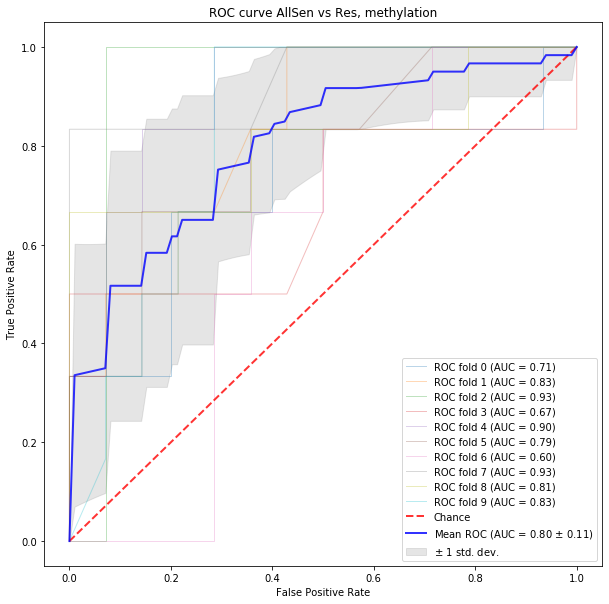

In [138]:
# ROC curve
classifier = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#classifier = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
#classifier = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.001, class_weight='balanced', random_state=42)
#classifier=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#classifier= LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve AllSen vs Res, methylation')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
 #         fancybox=True, shadow=True, ncol=5)
plt.legend(loc='lower right')
plt.savefig('1.png')

In [ ]:
k_fold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)
y_real = []
y_proba = []
#predictor= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
predictor = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
#predictor = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
#predictor = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=36851234)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC curve Res vs Senl')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.savefig('ROC_Res_vs_SenS.png')
#predictor = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
for i, (train_index, test_index) in enumerate(k_fold.split(X, y)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])
    
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, thr = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
#plt.show()
#plt.title('PR curve Res vs SenS')
#plt.savefig('PR curve Res vs Senl_RF.png')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
c_matrix=confusion_matrix(y_test, y_pred)
c_matrix